# **Imports**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# **Reading Data**

In [2]:
df = pd.read_csv('../Data/final_combined_data.csv')

# **Feature Engineering**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Latitude                   50000 non-null  float64
 1   Longitude                  50000 non-null  float64
 2   Altitude                   50000 non-null  float64
 3   Distance                   50000 non-null  float64
 4   Alignment                  50000 non-null  bool   
 5   Distance_Sensors           50000 non-null  float64
 6   Proximity                  50000 non-null  bool   
 7   Wheel_Speed                50000 non-null  float64
 8   Velocity                   50000 non-null  float64
 9   Hall_Effect                50000 non-null  bool   
 10  Emergency_Stop             50000 non-null  bool   
 11  Temperature                50000 non-null  float64
 12  Humidity                   50000 non-null  float64
 13  Light_Level                50000 non-null  flo

In [4]:
df.columns

Index(['Latitude', 'Longitude', 'Altitude', 'Distance', 'Alignment',
       'Distance_Sensors', 'Proximity', 'Wheel_Speed', 'Velocity',
       'Hall_Effect', 'Emergency_Stop', 'Temperature', 'Humidity',
       'Light_Level', 'Alignment_Label', 'Safety_Label',
       'Collision_Avoidance_Label', 'Chaining_Unchaining_Label'],
      dtype='object')

In [5]:
# Relative Position and Angle
df["Relative_Distance"] = df["Distance"].diff()
df["Relative_Angle"] = df["Longitude"].diff()

In [6]:
# Relative Velocity
df["Relative_Velocity"] = df["Velocity"].diff()

In [7]:
# Time Series Features
window_size = 10
df["Rolling_Mean_Wheel_Speed"] = df["Wheel_Speed"].rolling(window=window_size).mean()
df["Rolling_Max_Distance"] = df["Distance"].rolling(window=window_size).max()

In [8]:
# Safety and Emergency Features
df["Safety_Activation"] = (df["Hall_Effect"] | df["Emergency_Stop"]).astype(int)
df["Safety_Duration"] = df.groupby((df["Safety_Activation"] != df["Safety_Activation"].shift()).cumsum())["Safety_Activation"].cumcount()


In [9]:
# Environmental Conditions Interaction
df["Temp_Humidity_Interact"] = df["Temperature"] * df["Humidity"]
df["Light_Temp_Interact"] = df["Light_Level"] * df["Temperature"]

In [10]:
# Alignment and Proximity Trends
window_size = 10
df["Alignment_Percentage"] = df["Alignment"].rolling(window=window_size).mean() * 100
df["Proximity_Trend"] = df["Proximity"].rolling(window=window_size).sum()

In [11]:
# Interaction Features
df["Alignment_Velocity_Interaction"] = df["Alignment"] * df["Velocity"]

In [12]:
# Estimate time to collision
df["Time_To_Collision"] = df["Distance"] / df["Velocity"]

In [13]:
# Save the updated combined data with new features to a new CSV file
# df.to_csv("combined_data_with_features.csv", index=False)

print("Combined data with new features saved.")

Combined data with new features saved.


In [14]:
df.columns

Index(['Latitude', 'Longitude', 'Altitude', 'Distance', 'Alignment',
       'Distance_Sensors', 'Proximity', 'Wheel_Speed', 'Velocity',
       'Hall_Effect', 'Emergency_Stop', 'Temperature', 'Humidity',
       'Light_Level', 'Alignment_Label', 'Safety_Label',
       'Collision_Avoidance_Label', 'Chaining_Unchaining_Label',
       'Relative_Distance', 'Relative_Angle', 'Relative_Velocity',
       'Rolling_Mean_Wheel_Speed', 'Rolling_Max_Distance', 'Safety_Activation',
       'Safety_Duration', 'Temp_Humidity_Interact', 'Light_Temp_Interact',
       'Alignment_Percentage', 'Proximity_Trend',
       'Alignment_Velocity_Interaction', 'Time_To_Collision'],
      dtype='object')

In [15]:
df.shape

(50000, 31)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        50000 non-null  float64
 1   Longitude                       50000 non-null  float64
 2   Altitude                        50000 non-null  float64
 3   Distance                        50000 non-null  float64
 4   Alignment                       50000 non-null  bool   
 5   Distance_Sensors                50000 non-null  float64
 6   Proximity                       50000 non-null  bool   
 7   Wheel_Speed                     50000 non-null  float64
 8   Velocity                        50000 non-null  float64
 9   Hall_Effect                     50000 non-null  bool   
 10  Emergency_Stop                  50000 non-null  bool   
 11  Temperature                     50000 non-null  float64
 12  Humidity                        

In [17]:
df.isna().sum()

Latitude                          0
Longitude                         0
Altitude                          0
Distance                          0
Alignment                         0
Distance_Sensors                  0
Proximity                         0
Wheel_Speed                       0
Velocity                          0
Hall_Effect                       0
Emergency_Stop                    0
Temperature                       0
Humidity                          0
Light_Level                       0
Alignment_Label                   0
Safety_Label                      0
Collision_Avoidance_Label         0
Chaining_Unchaining_Label         0
Relative_Distance                 1
Relative_Angle                    1
Relative_Velocity                 1
Rolling_Mean_Wheel_Speed          9
Rolling_Max_Distance              9
Safety_Activation                 0
Safety_Duration                   0
Temp_Humidity_Interact            0
Light_Temp_Interact               0
Alignment_Percentage        

In [18]:
numerical_columns = ['Relative_Distance', 'Relative_Angle', 'Relative_Velocity', 'Rolling_Mean_Wheel_Speed', 
'Rolling_Max_Distance', 'Alignment_Percentage', 'Proximity_Trend']

mean_values = df[numerical_columns].mean()
df[numerical_columns] = df[numerical_columns].fillna(mean_values)


In [19]:
df.isna().sum()

Latitude                          0
Longitude                         0
Altitude                          0
Distance                          0
Alignment                         0
Distance_Sensors                  0
Proximity                         0
Wheel_Speed                       0
Velocity                          0
Hall_Effect                       0
Emergency_Stop                    0
Temperature                       0
Humidity                          0
Light_Level                       0
Alignment_Label                   0
Safety_Label                      0
Collision_Avoidance_Label         0
Chaining_Unchaining_Label         0
Relative_Distance                 0
Relative_Angle                    0
Relative_Velocity                 0
Rolling_Mean_Wheel_Speed          0
Rolling_Max_Distance              0
Safety_Activation                 0
Safety_Duration                   0
Temp_Humidity_Interact            0
Light_Temp_Interact               0
Alignment_Percentage        

# **Prepping data for Prediction**

In [20]:
# Define the categorical columns for one-hot encoding
categorical_columns = ['Alignment_Label', 'Safety_Label', 'Collision_Avoidance_Label']

In [21]:
# Apply one-hot encoding to categorical columns
encoder = OneHotEncoder(sparse=False, drop="first")  # Drop the first category to avoid multicollinearity
encoded_features = encoder.fit_transform(df[categorical_columns])

/home/lowin/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
# Get the category names from the encoder
category_names = encoder.get_feature_names_out(input_features=categorical_columns)

In [23]:
# Create a DataFrame for the encoded features with proper column names
encoded_df = pd.DataFrame(encoded_features, columns=category_names)

In [24]:
# Concatenate the encoded features with the original data
data_encoded = pd.concat([df, encoded_df], axis=1)

In [25]:
data_encoded.columns

Index(['Latitude', 'Longitude', 'Altitude', 'Distance', 'Alignment',
       'Distance_Sensors', 'Proximity', 'Wheel_Speed', 'Velocity',
       'Hall_Effect', 'Emergency_Stop', 'Temperature', 'Humidity',
       'Light_Level', 'Alignment_Label', 'Safety_Label',
       'Collision_Avoidance_Label', 'Chaining_Unchaining_Label',
       'Relative_Distance', 'Relative_Angle', 'Relative_Velocity',
       'Rolling_Mean_Wheel_Speed', 'Rolling_Max_Distance', 'Safety_Activation',
       'Safety_Duration', 'Temp_Humidity_Interact', 'Light_Temp_Interact',
       'Alignment_Percentage', 'Proximity_Trend',
       'Alignment_Velocity_Interaction', 'Time_To_Collision',
       'Alignment_Label_Not_Aligned', 'Safety_Label_Unsafe',
       'Collision_Avoidance_Label_Medium_Risk'],
      dtype='object')

In [26]:
data_encoded.isna().sum()

Latitude                                 0
Longitude                                0
Altitude                                 0
Distance                                 0
Alignment                                0
Distance_Sensors                         0
Proximity                                0
Wheel_Speed                              0
Velocity                                 0
Hall_Effect                              0
Emergency_Stop                           0
Temperature                              0
Humidity                                 0
Light_Level                              0
Alignment_Label                          0
Safety_Label                             0
Collision_Avoidance_Label                0
Chaining_Unchaining_Label                0
Relative_Distance                        0
Relative_Angle                           0
Relative_Velocity                        0
Rolling_Mean_Wheel_Speed                 0
Rolling_Max_Distance                     0
Safety_Acti

# **Machine Learning**

In [27]:
features = ['Latitude', 'Longitude', 'Altitude', 'Distance', 'Alignment',
       'Distance_Sensors', 'Proximity', 'Wheel_Speed', 'Velocity',
       'Hall_Effect', 'Emergency_Stop', 'Temperature', 'Humidity',
       'Light_Level', 'Relative_Distance', 'Relative_Angle', 'Relative_Velocity',
       'Rolling_Mean_Wheel_Speed', 'Rolling_Max_Distance', 'Safety_Activation',
       'Safety_Duration', 'Temp_Humidity_Interact', 'Light_Temp_Interact',
       'Alignment_Percentage', 'Proximity_Trend',
       'Alignment_Velocity_Interaction', 'Time_To_Collision',
       'Alignment_Label_Not_Aligned', 'Safety_Label_Unsafe',
       'Collision_Avoidance_Label_Medium_Risk']

target = 'Chaining_Unchaining_Label'

X = data_encoded[features]
y = data_encoded[target]

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [29]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Initialize a Random Forest classifier with adjusted hyperparameters
model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, random_state=101)

In [31]:
# Implement cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Mean CV Score:", np.mean(scores))

Cross-Validation Scores: [0.99975  1.       1.       1.       0.999875]
Mean CV Score: 0.999925


In [32]:
# Train the classifier on the entire training data
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=101)

In [33]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

In [34]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


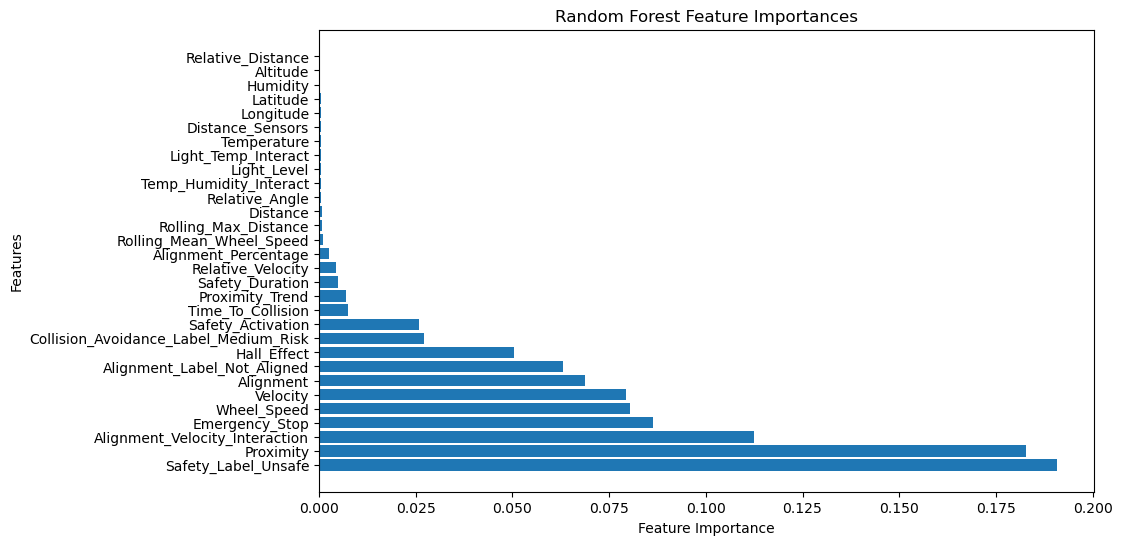

In [35]:
# Get feature importances
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.show()

In [36]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data['predicted_condition'] = y_pred
test_data

,Latitude,Longitude,Altitude,Distance,Alignment,Distance_Sensors,Proximity,Wheel_Speed,Velocity,Hall_Effect,...,Light_Temp_Interact,Alignment_Percentage,Proximity_Trend,Alignment_Velocity_Interaction,Time_To_Collision,Alignment_Label_Not_Aligned,Safety_Label_Unsafe,Collision_Avoidance_Label_Medium_Risk,Chaining_Unchaining_Label,predicted_condition
18447,37.450773,-121.560116,38.432356,0.1341,True,2.215634,True,1.230795,0.369239,False,...,2862.848965,80.0,10.0,0.369239,0.363180,0.0,1.0,0.0,Unchaining,Unchaining
17768,37.096169,-121.466890,87.883047,0.2304,True,2.686541,True,3.636172,1.090852,True,...,12262.750387,80.0,7.0,1.090852,0.211211,0.0,1.0,0.0,Unchaining,Unchaining
45879,37.110201,-121.861591,79.611548,0.2637,True,3.420189,True,4.960941,1.488282,True,...,10605.562432,100.0,7.0,1.488282,0.177184,0.0,0.0,0.0,Unchaining,Unchaining
16972,37.161181,-121.809373,43.082467,0.2916,False,4.199308,True,0.900559,0.270168,True,...,3842.596648,50.0,7.0,0.000000,1.079329,1.0,0.0,0.0,Unchaining,Unchaining
12165,37.817096,-121.941849,34.680305,0.0495,False,3.614991,False,3.561616,1.068485,True,...,10064.143703,80.0,6.0,0.000000,0.046327,1.0,0.0,0.0,Unchaining,Unchaining
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40899,37.608635,-121.247710,98.772346,0.2697,True,4.850218,False,1.005806,0.301742,True,...,12161.150765,80.0,7.0,0.301742,0.893810,0.0,0.0,1.0,Unchaining,Unchaining
7806,37.610969,-121.787608,26.347262,0.2418,True,1.212808,True,3.474732,1.042420,True,...,17756.518541,80.0,8.0,1.042420,0.231960,0.0,1.0,0.0,Unchaining,Unchaining
41481,37.127629,-121.234978,58.891676,0.1443,True,2.832965,True,1.925559,0.577668,True,...,6024.119186,70.0,9.0,0.577668,0.249798,0.0,0.0,0.0,Chaining,Chaining
21802,37.476011,-121.882736,66.141464,0.2406,True,1.922109,True,1.583506,0.475052,True,...,5584.679767,60.0,8.0,0.475052,0.506471,0.0,0.0,0.0,Chaining,Chaining


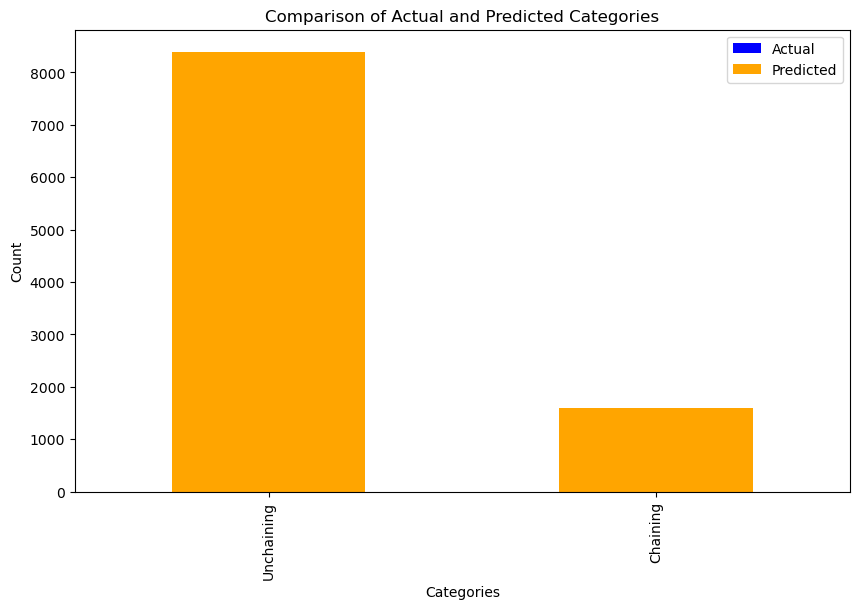

In [37]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Create a DataFrame to compare actual and predicted categories
comparison_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot a bar plot to compare actual and predicted categories
plt.figure(figsize=(10, 6))
comparison_data["Actual"].value_counts().plot(kind='bar', color='blue', label='Actual')
comparison_data["Predicted"].value_counts().plot(kind='bar', color='orange', label='Predicted')
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Comparison of Actual and Predicted Categories")
plt.legend()
plt.show()


In [38]:
df['Chaining_Unchaining_Label'].unique()

array(['Unchaining', 'Chaining'], dtype=object)

In [40]:
df.groupby(['Safety_Label']).count()
df.columns


# max_distance = 5.0  
# min_distance = 2.0

# # Cart wheel speed treshold in meters per second (m/s) for chaining 
# high_speed = 1.5

# # Define conditions for chaining based on the data
# chaining_conditions = [
#     alignment and distance > min_distance and distance < max_distance and not proximity and wheel_speed < high_speed and safety_label == "Safe"
    

selected_data = df[
    (df['Distance_Sensors'] > 0.5) & (df['Distance_Sensors'] < 5) &
    (df['Proximity'] == True) & (df['Alignment'] == True) &
    (df['Wheel_Speed'] < 2.5) & (df['Safety_Label'] == 'Safe')
]
selected_data
# df[(df['Safety_Label'] == 'Safe')].count()
# df[df['Wheel_Speed'] < 2.5].count()

,Latitude,Longitude,Altitude,Distance,Alignment,Distance_Sensors,Proximity,Wheel_Speed,Velocity,Hall_Effect,...,Rolling_Mean_Wheel_Speed,Rolling_Max_Distance,Safety_Activation,Safety_Duration,Temp_Humidity_Interact,Light_Temp_Interact,Alignment_Percentage,Proximity_Trend,Alignment_Velocity_Interaction,Time_To_Collision
11,37.852811,-121.572428,52.355375,0.0033,True,4.245780,True,0.666662,0.199999,True,...,2.934382,0.0033,1,9,1907.955238,3204.924421,60.0,7.0,0.199999,0.016500
13,37.852811,-121.572426,52.355375,0.0039,True,3.661998,True,1.050540,0.315162,True,...,2.619838,0.0039,1,11,779.297669,15627.131297,60.0,7.0,0.315162,0.012375
19,37.852810,-121.572420,52.355375,0.0057,True,3.765334,True,1.840932,0.552280,True,...,2.752482,0.0057,1,0,624.686512,1774.959413,80.0,7.0,0.552280,0.010321
41,37.852810,-121.572398,52.355375,0.0123,True,4.962585,True,1.784835,0.535451,True,...,3.088009,0.0123,1,5,1200.061405,10566.898892,50.0,9.0,0.535451,0.022971
51,37.852809,-121.572388,52.355375,0.0153,True,2.886867,True,2.426363,0.727909,True,...,2.860727,0.0153,1,1,588.601834,5842.894529,60.0,6.0,0.727909,0.021019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,37.472993,-121.499317,20.414271,0.2901,True,3.978833,True,1.565004,0.469501,True,...,2.495583,0.2901,1,2,608.091708,11901.151445,80.0,10.0,0.469501,0.617890
49968,37.472992,-121.499316,20.414271,0.2904,True,1.431410,True,0.884167,0.265250,True,...,2.101116,0.2904,1,3,701.711682,11489.437959,90.0,10.0,0.265250,1.094816
49969,37.472991,-121.499316,20.414271,0.2907,True,3.254274,True,1.351376,0.405413,True,...,2.028159,0.2907,1,4,536.353329,6089.629461,90.0,10.0,0.405413,0.717047
49990,37.472974,-121.499304,20.414271,0.2970,True,2.160624,True,1.574003,0.472201,True,...,2.939805,0.2970,1,12,846.211596,12428.331211,70.0,6.0,0.472201,0.628969
